## Import libraries

In [1]:
import numpy as np

from src.preprocessing import *
from src.binary_model import LogisticRegressionBinary
from src.multiclass_model import LogisticRegressionMulti
from src.evaluation import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## load data & simple tests

In [12]:
!./download.sh

mkdir: cannot create directory ‘data’: File exists
--2020-04-15 14:14:12--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 104.28.7.204, 2606:4700:3033::681c:7cc, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9,5M) [application/x-gzip]
Saving to: ‘data/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9,45M  5,02MB/s    in 1,9s    

2020-04-15 14:14:14 (5,02 MB/s) - ‘data/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2020-04-15 14:14:14--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.7.204, 104.28.6.204, 2606:4700:3031::681c:6cc, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.7.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘data/tra

In [2]:
!pytest

============================= test session starts ==============================
platform linux -- Python 3.6.10, pytest-4.4.1, py-1.8.0, pluggy-0.9.0
rootdir: /home/timur/code/allegro_test
plugins: remotedata-0.3.1, openfiles-0.3.2, doctestplus-0.3.0, arraydiff-0.3
collected 9 items                                                              

test_function.py ....                                                    [ 44%]
test_models.py .....                                                     [100%]

=============================== warnings summary ===============================
test_models.py::test_model_random_states[seed0]
test_models.py::test_model_random_states[seed1]
test_models.py::test_save_load
  /home/timur/code/allegro_test/src/binary_model.py:114: RuntimeWarning: overflow encountered in exp
    return 1/(1+np.exp(-x))

test_models.py::test_save_load
  /home/timur/code/allegro_test/src/binary_model.py:127: RuntimeWarning: overflow encountered in exp
    loss_batch = np.l

In [3]:
def is_composite(y: np.ndarray) -> np.ndarray:
    return np.where(np.isin(y, [4,6,8,9]), 1,-1)

In [4]:
X, y = load_data("train")

X = X.reshape(-1,28*28)
y = y.reshape(-1, 1)
# +1 - liczba złożona; -1 - liczba prosta
y_comp = is_composite(y)

# Przeskalowanie danych
scaler = Scaler()
scaler.fit(X)
X_scaled = scaler.standardize(X)

## simple EDA

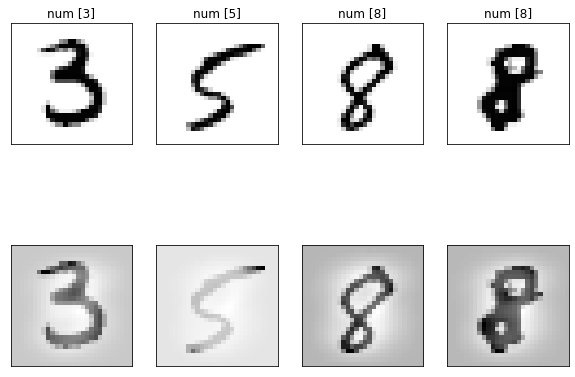

In [5]:
fig = plt.figure(figsize=(10, 15)) 
row, col = 2, 4

for i in range(1, col+1):
    img_idx = np.random.randint(0,high=X.shape[0])
    
    fig.add_subplot(2, col, i)
    plt.imshow(X[img_idx].reshape(28,28), cmap="Greys")
    plt.title(f"num {y[img_idx]}")
    plt.xticks([]), plt.yticks([])
    
    fig.add_subplot(1, col, i)
    plt.imshow(X_scaled[img_idx].reshape(28,28), cmap="Greys")
    plt.xticks([]), plt.yticks([])


#### At the bottom we can see scaled images

#### Check class balance

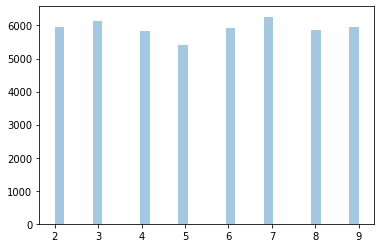

In [6]:
sns.distplot(y, kde=False);

#### Check whether we have balanced distribution across ~10 folds

In [7]:
for i in range(10):
    _, counts = np.unique(y[4000*i:4000*(i+1)],return_counts=True)
    print(counts, f"mean = {np.mean(counts)}, std = {np.std(counts)}")

[490 498 541 436 508 556 471 500] mean = 500.0, std = 35.21718330588067
[523 552 450 440 520 530 487 498] mean = 500.0, std = 36.752550931874104
[473 529 496 466 486 533 489 528] mean = 500.0, std = 24.829418035870273
[473 527 498 463 491 512 505 531] mean = 500.0, std = 22.477766792989023
[530 528 505 463 499 508 481 486] mean = 500.0, std = 21.50581316760657
[503 494 482 482 521 520 490 508] mean = 500.0, std = 14.568802284333465
[508 511 489 446 491 517 505 533] mean = 500.0, std = 24.253865671269807
[511 504 509 459 520 515 490 492] mean = 500.0, std = 18.33030277982336
[504 501 466 467 499 549 496 518] mean = 500.0, std = 25.0099980007996
[525 535 494 455 493 511 516 471] mean = 500.0, std = 25.441108466417102


#### We have balanced classes, so it is enough to do only hold-out model validation

In [8]:
# train/val  80/20
val_split = int(X.shape[0] * 0.8)

X_train_scaled, X_val_scaled = np.split(X_scaled, [val_split])

y_train, y_val = np.split(y, [val_split])
y_train_comp, y_val_comp = np.split(y_comp, [val_split])

## Binary Logistic regression 

In [21]:
logreg_binary = LogisticRegressionBinary(C=3, learning_rate_init=0.001, alpha=0.9, weight_decay=0.9, max_iter=10,
                                         batch_size= 32, verbose=False, val_split=0.9)

In [22]:
logreg_binary.fit(X_train_scaled, y_train_comp);

#### Check accuracy on validation data

In [23]:
accuracy(logreg_binary,X_val_scaled,y_val_comp)

0.8734551600295765

#### We want to predict mathematical property based on image. It is contrintuitive approach, so we can build model to predict number and based on that number we can get mathematical proprety. From this reason I will use multinomial logistic regression

## Multinomial Logistic regression

This model inherits from binary logistic regression. New loss function and analytic gradient is provided

In [31]:
logreg_multi = LogisticRegressionMulti(C=3, learning_rate_init=0.01, alpha=0.9,
                                         weight_decay=0.9, max_iter=10, batch_size= 32 ,verbose=False,
                                         val_split=0.9, num_classes=8, random_state=25)

In [32]:
logreg_multi.fit(X_train_scaled, y_train);

Stopping criteria is met!


In [33]:
accuracy(logreg_multi, X_val_scaled, y_val)

0.8814830463716067

#### Potencially, this model has bigger capacity, so results will be better. As we can see after few epochs result has improved 

#### Create confusion matrix to see potencial problems of our model

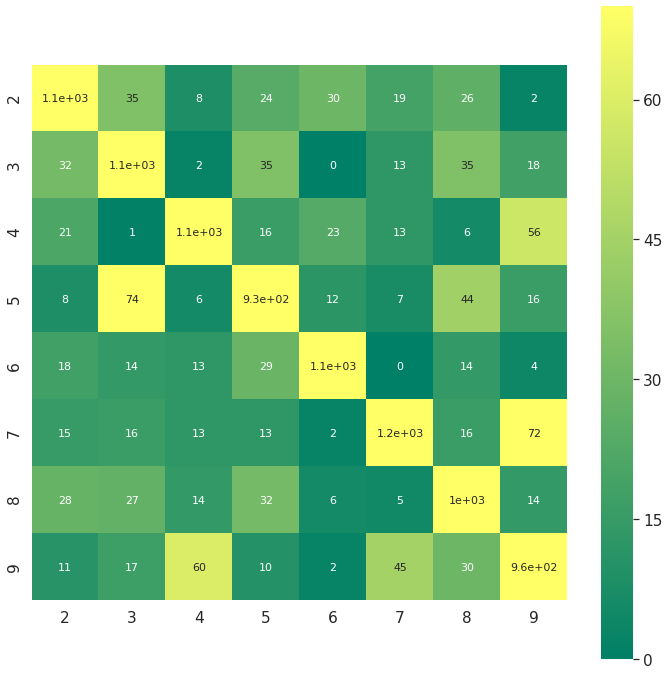

In [34]:
preds = logreg_multi.predict(X_val_scaled)
confusion_matrix(preds, y_val.ravel());

In [35]:
preds_comp = logreg_multi.predict_composite(X_val_scaled)
acc_comp = sum(preds_comp == y_val_comp.ravel()) / len(y_val_comp)
print(acc_comp)

0.9377838808492659


## Search hyperparameters 

I performed search of hyperparameters in google colab. Moreover, tryed PCA+Polymomials features approach.

## Results on test data

#### Used  logreg_rs_colab.ipynb to train and evaluate model on PCA+Polynomials data

#### Accuracy test data : 95,47% - number classification
#### Accuracy test data : 97,29% - composite number test 